# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [357]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [358]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

In [1]:
# The PyMAPDL Host (X.X.X.X IP Address) and Port (XXX) are pulled from the environment 
import os
HOST = os.getenv("MAPDL_HOST")
if HOST is None:
    raise ValueError(
        "Unable to read $MAPDL_HOST from the environment. "
        + "Use 'export MAPDL_HOST=X.X.X.X' for local IP address of your MAPDL Instance."
    )
PORT = os.getenv("MAPDL_PORT")
if PORT is None:
    raise ValueError(
        "Unable to read $MAPDL_PORT from the environment. "
        + "Use 'export MAPDL_PORT=X' for the port of your MAPDL Instance."
    )


## Design Space Tesseract

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference
from utils import hex_to_pyvista, plot_grid, plot_grid_slice, plot_mesh, stop_grads_int

from tesseract_jax import apply_tesseract

In [3]:
design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
bar_3d_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [4]:
n_chains = 2
n_edges_per_chain = 3
bar_radius = 1.2

Lx, Ly, Lz = 20.0, 5.0, 10.0
Nx, Ny, Nz = 64, 16, 32

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 2].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

initial_params = initial_params.flatten()

normalization_factors = jnp.ones_like(initial_params, dtype=jnp.float32) * 0.1
initial_params = initial_params * normalization_factors
normalization_bias = jnp.zeros_like(initial_params, dtype=jnp.float32)


design_inputs = {
    "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
    "static_parameters": [n_chains, n_edges_per_chain + 1],
    "string_parameters": [],
    "mesh_tesseract": TesseractReference(bar_3d_tess),
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "epsilon": 0.001,  # epsilon, only used for FD of the jacobian
    "grid_center": [0.0, 0.0, 0.0],
    "max_points": 2000,
    "max_faces": 4000,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "normalize_jacobian": False,
    "precompute_jacobian": False,
    "sdf_backend": "pyvista",
}

design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Number of vertices: 202
Number of faces: 400
SDF shape: (64, 16, 32)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

[-1.          0.         -0.08333334 -0.33333328  0.         -0.08333334
  0.3333334   0.         -0.08333334  1.          0.         -0.08333334
 -1.          0.          0.08333334 -0.33333328  0.          0.08333334
  0.3333334   0.          0.08333334  1.          0.          0.08333334]


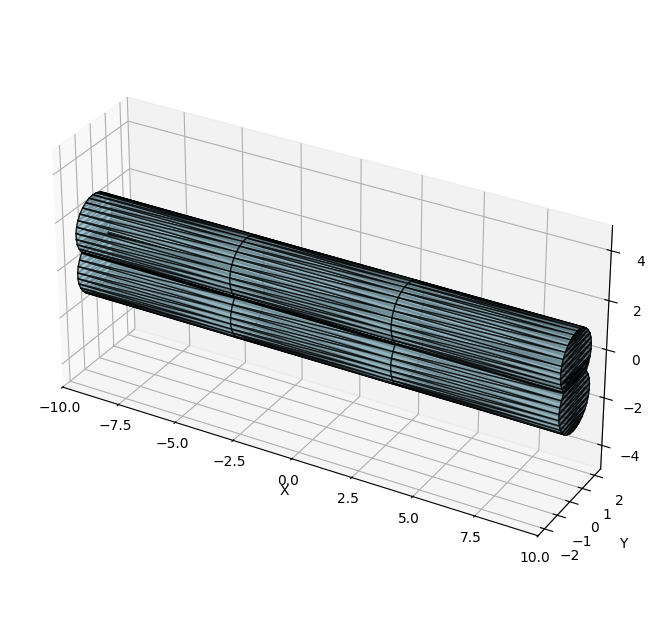

In [5]:
print(initial_params)
plot_mesh(mesh, [Lx, Ly, Lz])

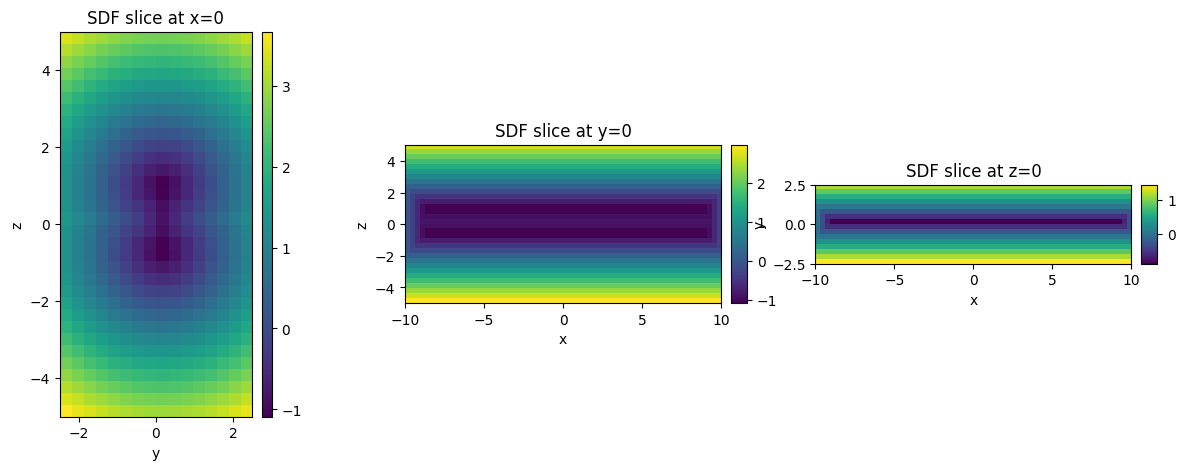

In [6]:
plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

In [7]:
result = design_tess.jacobian(
    inputs={
        "differentiable_parameters": initial_params,
        **design_inputs,
    },
    jac_inputs=["differentiable_parameters"],
    jac_outputs=["sdf"],
)

Computing Jacobian...


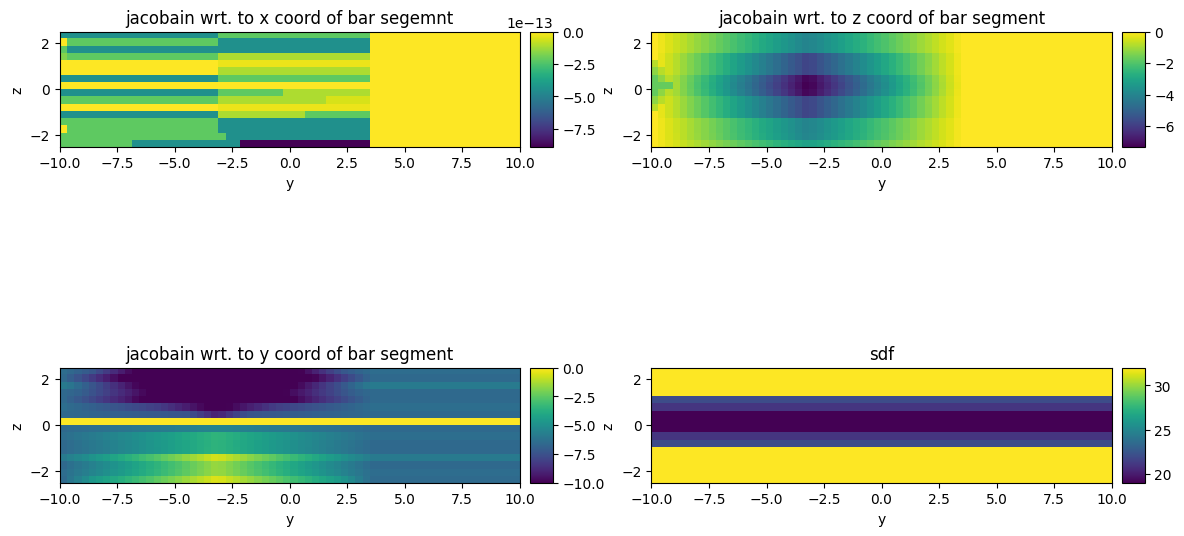

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][3], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 0],
    title="jacobain wrt. to x coord of bar segemnt",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][4], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 0],
    title="jacobain wrt. to y coord of bar segment",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][5], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="jacobain wrt. to z coord of bar segment",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.sum(sdf > 0, 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 1],
    title="sdf",
    xlabel="y",
    ylabel="z",
)

## Density Variation

rho min: 0.0007239776896312833, rho max: 0.9071784019470215


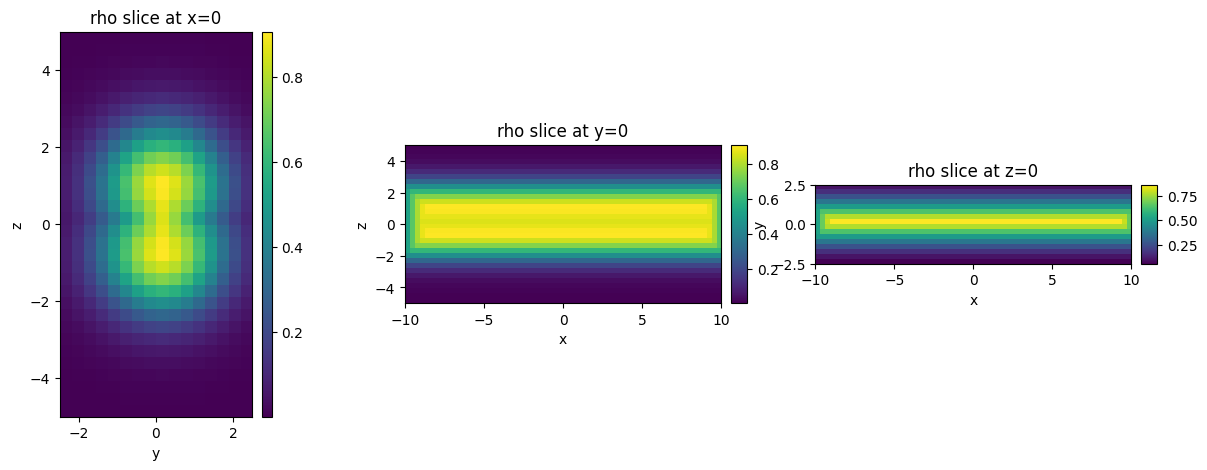

In [10]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho = sdf_to_rho(sdf, scale=2)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

## Hex Mesh

In [11]:
import pyvista as pv
import numpy as np

grid = pv.ImageData(
    dimensions=np.array((Nx, Ny, Nz)) + 1,
    origin=(-Lx / 2, -Ly / 2, -Lz  / 2),
    spacing=(Lx / Nx, Ly / Ny, Lz / Nz),  # These are the cell sizes along each axis
)
# repeated casts will eventually expose cell_connectivitiy
mesh = (
    grid.cast_to_structured_grid()
    .cast_to_explicit_structured_grid()
    .cast_to_unstructured_grid()
)

hex_mesh = {
    "points": mesh.points,
    "faces": mesh.cell_connectivity.reshape((Nx * Ny * Nz, 8)),
}
print(hex_mesh)

{'points': pyvista_ndarray([[-10.    ,  -2.5   ,  -5.    ],
                 [ -9.6875,  -2.5   ,  -5.    ],
                 [ -9.375 ,  -2.5   ,  -5.    ],
                 ...,
                 [  9.375 ,   2.5   ,   5.    ],
                 [  9.6875,   2.5   ,   5.    ],
                 [ 10.    ,   2.5   ,   5.    ]], shape=(36465, 3)), 'faces': array([[    0,     1,    66, ...,  1106,  1171,  1170],
       [    1,     2,    67, ...,  1107,  1172,  1171],
       [    2,     3,    68, ...,  1108,  1173,  1172],
       ...,
       [35291, 35292, 35357, ..., 36397, 36462, 36461],
       [35292, 35293, 35358, ..., 36398, 36463, 36462],
       [35293, 35294, 35359, ..., 36399, 36464, 36463]], shape=(32768, 8))}


Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [12]:
# Lets export it to a .vtk using pyvista

# TODO look at this transpose
pv_mesh = hex_to_pyvista(
    hex_mesh["points"],
    hex_mesh["faces"],
    {"rho": rho.T.flatten()},
)

print(pv_mesh)

pv_mesh.save("bars_mesh.vtk")

UnstructuredGrid (0x787500347580)
  N Cells:    32768
  N Points:   36465
  X Bounds:   -1.000e+01, 1.000e+01
  Y Bounds:   -2.500e+00, 2.500e+00
  Z Bounds:   -5.000e+00, 5.000e+00
  N Arrays:   1


## Boundary Conditions

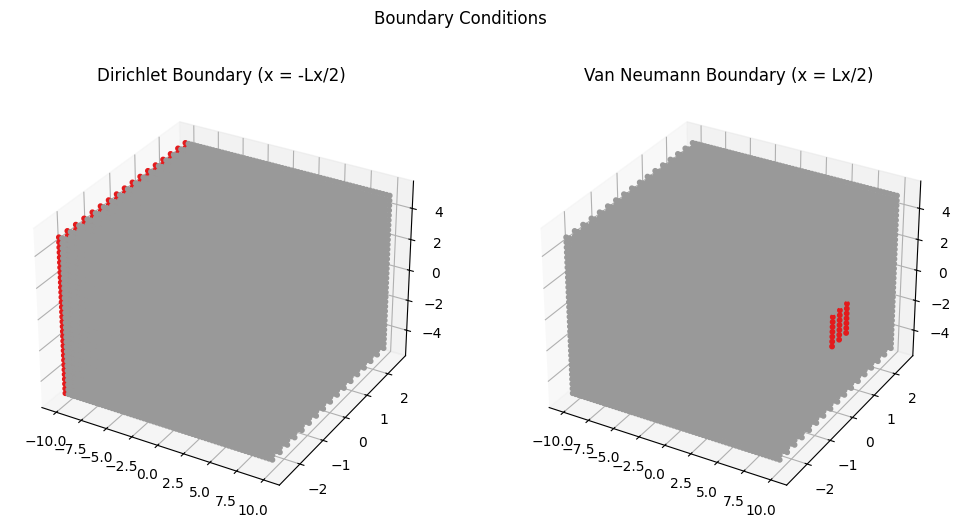

In [13]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Ly: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2
    # von Neumann condition (select nodes at x=Lx with constraints on y and z)
    x_lim = Lx/2
    y_min = -0.1 * Ly
    y_max = 0.1 * Ly
    z_min = -0.1 * Lz
    z_max = 0.1 * Lz
    van_neumann_mask = jnp.logical_and(
        hex_mesh["points"][:, 0] >= x_lim,
        jnp.logical_and(
            jnp.logical_and(
                hex_mesh["points"][:, 1] >= y_min, hex_mesh["points"][:, 1] <= y_max
            ),
            jnp.logical_and(
                hex_mesh["points"][:, 2] >= z_min, hex_mesh["points"][:, 2] <= z_max
            ),
        ),
    )


    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(hex_mesh, Lx, Ly, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
pts = hex_mesh["points"]
axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask, 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask, 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

## Finite Element Analysis

In [15]:
# load the Finite Element Method Tesseract
fem_tess = Tesseract.from_tesseract_api("pymapdl_tess/tesseract_api.py")


In [16]:
# TODO unify this framework
dirichlet_idx = np.where(dirichlet_mask)[0]
von_neumann_idx = np.where(van_neumann_mask)[0]
von_neumann_values = np.array([0, 0.0, 0.1]) + np.zeros((von_neumann_idx.shape[0], 3))

# TODO again note the transpose on rho!
inputs = {
    "dirichlet_mask": dirichlet_idx,
    "dirichlet_values": np.zeros(dirichlet_idx.size),
    "van_neumann_mask": von_neumann_idx,
    "van_neumann_values": von_neumann_values,
    "hex_mesh": hex_mesh,
    "host": HOST,
    "port": PORT,
    "rho": rho.T.reshape((hex_mesh["faces"].shape[0], 1)),
    "E0": 1.0,
    "rho_min": 1e-6,
    "log_level": "DEBUG",
    "vtk_output": "mesh_density.vtk",
}

compliance = fem_tess.apply(inputs)["compliance"]
print(f"Compliance: {compliance:.4f}")

2025-11-24 18:33:18,523 - tesseract_api - INFO - Starting solve...
2025-11-24 18:33:18,525 - tesseract_api - INFO - Starting SIMP elasticity analysis...
2025-11-24 18:33:18,526 - tesseract_api - INFO - Starting _create_mesh...
2025-11-24 18:33:18,605 - tesseract_api - INFO - Starting _define_element...
2025-11-24 18:33:18,681 - tesseract_api - INFO - Completed _define_element in 0.0761 seconds
2025-11-24 18:33:18,683 - tesseract_api - INFO - Creating 36465 nodes...
2025-11-24 18:33:22,788 - tesseract_api - INFO - Creating 32768 hexahedral elements...
2025-11-24 18:33:26,536 - tesseract_api - INFO - Mesh created: 36465 nodes, 32768 elements
2025-11-24 18:33:26,538 - tesseract_api - INFO - Verified: Node and element numbering is sequential (1, 2, 3, ...)
2025-11-24 18:33:26,540 - tesseract_api - INFO - Completed _create_mesh in 8.0139 seconds
2025-11-24 18:33:26,540 - tesseract_api - INFO - Starting _define_simp_materials...
2025-11-24 18:33:31,766 - tesseract_api - INFO - Completed _def

Compliance: 2790.6909


## Optimization Setup

In [17]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    # params = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {"differentiable_parameters": params.flatten(), **design_inputs},
    )

    sdf = design_out["sdf"]

    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=2)

    rho_grid = identity_and_store_grads(rho_grid, iteration + 2000)

    # calculate BCs
    dirichlet_mask, van_neumann_mask = get_boundary_masks(hex_mesh, Lx, Ly, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, 0.1]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    # TODO unify this framework
    dirichlet_idx = np.where(dirichlet_mask)[0]
    von_neumann_idx = np.where(van_neumann_mask)[0]
    von_neumann_values = np.array([0, 0.0, 0.1]) + np.zeros((von_neumann_idx.shape[0], 3))
    
    # TODO again note the transpose on rho!
    rho_for_fea = rho_grid.T.reshape((hex_mesh["faces"].shape[0], 1))

    c = apply_tesseract(
        fem_tess,
        {
            "dirichlet_mask": dirichlet_idx,
            "dirichlet_values": np.zeros(dirichlet_idx.size),
            "van_neumann_mask": von_neumann_idx,
            "van_neumann_values": von_neumann_values,
            "hex_mesh": hex_mesh,
            "host": HOST,
            "port": PORT,
            "rho": rho_for_fea,
            "E0": 1.0,
            "rho_min": 1e-6,
            "log_level": "WARNING",
            "vtk_output": None,
        },
    )["compliance"]

    return c, {
        "sdf": sdf,
        "rho_grid": rho_grid
    }


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)
grad_fn = jax.value_and_grad(loss, has_aux=True)


## Lets have a look at the gradients

In [66]:
fem_tess = Tesseract.from_tesseract_api("pymapdl_tess/tesseract_api.py")

print(hex_mesh)
(loss_value, aux), grads = grad_fn(initial_params, iteration=0)
print(f"loss {loss_value}, grads {grads}")

{'points': pyvista_ndarray([[-10.   ,  -2.5  ,  -5.   ],
                 [ -9.375,  -2.5  ,  -5.   ],
                 [ -8.75 ,  -2.5  ,  -5.   ],
                 ...,
                 [  8.75 ,   2.5  ,   5.   ],
                 [  9.375,   2.5  ,   5.   ],
                 [ 10.   ,   2.5  ,   5.   ]], shape=(5049, 3)), 'faces': array([[   0,    1,   34, ...,  298,  331,  330],
       [   1,    2,   35, ...,  299,  332,  331],
       [   2,    3,   36, ...,  300,  333,  332],
       ...,
       [4715, 4716, 4749, ..., 5013, 5046, 5045],
       [4716, 4717, 4750, ..., 5014, 5047, 5046],
       [4717, 4718, 4751, ..., 5015, 5048, 5047]], shape=(4096, 8))}
Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
loss 56.780555725097656, grads [ 5.8516460e+01  5.9979450e+01  1.8890259e+02  1.2061572e-12
  6.4647842e+01  1.8341995e+02 -3.5661639e-14  6.2553024e+01
  4.6782925e+01 -1.1716251e+00  6.0950508e+01  2.4376881e+00
  5.8517517e+01  5.9959007e+01 -1.879634

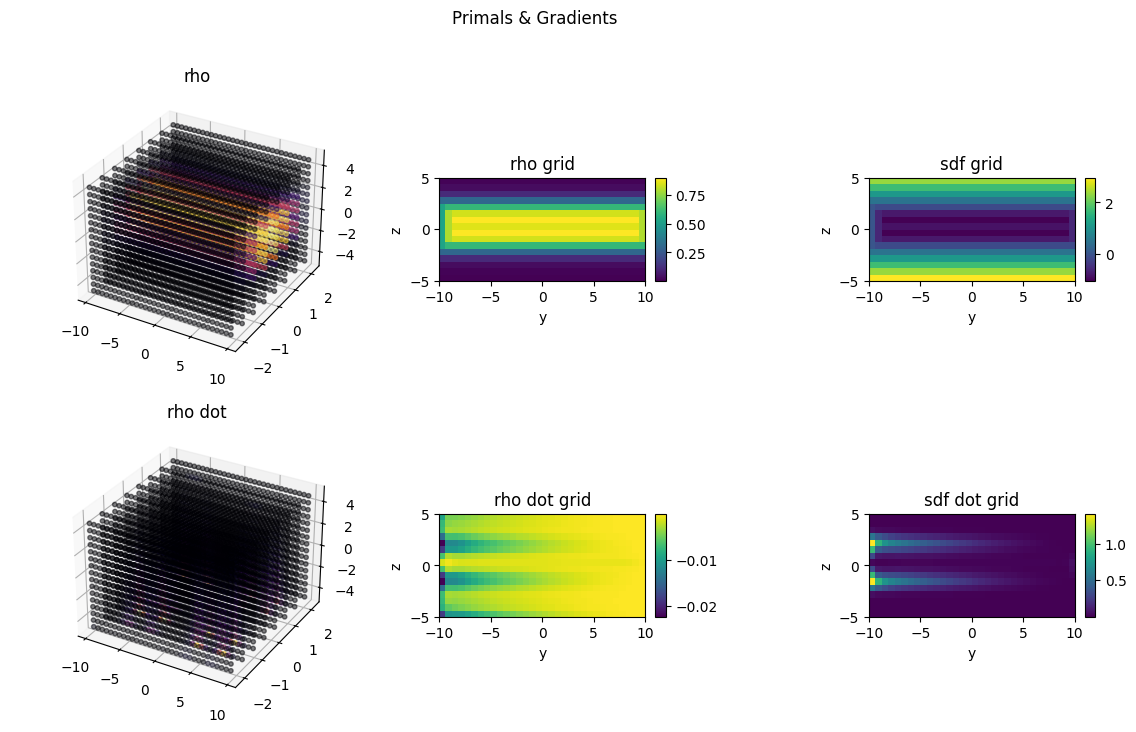

In [67]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
plt.suptitle("Primals & Gradients")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

ax = axs[0, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

ax = axs[1, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

# Set the first two subplots to 3D
axs[0, 0] = fig.add_subplot(2, 2, 1, projection="3d")
axs[1, 0] = fig.add_subplot(2, 2, 3, projection="3d")


mesh = hex_mesh

pts_coords = mesh["points"]
hex_cells = mesh["faces"]
pts = jnp.mean(pts_coords[hex_cells], axis=1)

axs[0, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=rho.T,
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[0, 0].set_title("rho")

axs[1, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=-grad_storage[2000][1],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[1, 0].set_title("rho dot")

plot_grid_slice(
    aux["rho_grid"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 1],
    title="rho grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[2000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 1],
    title="rho dot grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    aux["sdf"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 2],
    title="sdf grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[1000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 2],
    title="sdf dot grid",
    xlabel="y",
    ylabel="z",
)

fig.subplots_adjust(wspace=0.9)
# fig.tight_layout(w_pad=3.0)

### Finite difference check

In [68]:
params = initial_params.copy()

(loss_value, aux), grads = grad_fn(params, iteration=0)

# Finite difference check
run_central_difference = False
num_tests = 3
FD_delta = 1.0e-4
FD_grads = 0 * np.array(grads)
for i in range(num_tests):
    print(i)
    params_up = params.at[i].add(FD_delta)
    (fupp, _), _ = grad_fn(params_up, iteration=i*2)

    if run_central_difference:
        params_down = params.at[i].subtract(2.0 * FD_delta)
        (fdown, _), _ = grad_fn(params_down, iteration=i*2+1)
        FD_grads[i] = (fupp - fdown) / FD_delta / 2.0

    else:
        FD_grads[i] = (fupp - loss_value) / FD_delta

if num_tests > 0:
    sens = np.array(grads[0:num_tests])
    FD_sens = FD_grads[0:num_tests]
    print(sens)
    print(FD_sens)
    errors = sens - FD_sens
    print(errors)
    rel_abs_error = np.abs(errors / sens)
    if run_central_difference:
        print(f"Relative error should be near O({FD_delta})")
    else:
        print(f"Relative error should be O({FD_delta * 10})")
    print(rel_abs_error)

Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
0
Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
1
Storing values in hash 2002
Storing values in hash 1002
Computing Jacobian...
2
Storing values in hash 2004
Storing values in hash 1004
Computing Jacobian...
[ 58.51646  59.97945 188.90259]
[ 52.947998    4.6920776 188.29346  ]
[ 5.5684624  55.287373    0.60913086]
Relative error should be O(0.001)
[0.09516062 0.9217719  0.00322458]


## Design Optimization using MMA

In [18]:
import mmapy
import numpy as np
from tesseract_core.runtime import Array, Differentiable, Float32, Int32


class MMAOptimizer:
    """A wrapper for the MMA optimizer from mmapy.
    github.com/arjendeetman/GCMMA-MMA-Python
    mmapy is a pretty barebones implementation of MMA in python. It should work for now.
    Alternatives to consider:
    - github.com/LLNL/pyMMAopt
    - pyopt.org/reference/optimizers.mma.html

    """

    def __init__(
        self,
        x_init: Array[(None,), Float32],
        x_min: Array[(None,), Float32],
        x_max: Array[(None,), Float32],
        num_constraints: Array[(), Int32],
        constraint_scale: Array[(), Float32] = 1000.0,
        x_update_limit: Array[(), Float32] = 0.1,
    ) -> None:
        self.n = x_init.shape[0]
        self.m = num_constraints
        self.__check_input_sizes(x_init, x_min, x_max)

        # follow the original MMA variable names...
        self.asyinit = 0.5
        self.asyincr = 1.2
        self.asydecr = 0.7
        self.objective_scale: Array[(), Float32] = 100.0
        self.objective_scale_factor: Array[(), Float32] = 1.0

        self.eeen = np.ones((self.n, 1))
        self.eeem = np.ones((self.m, 1))
        self.zeron = np.zeros((self.n, 1))
        self.zerom = np.zeros((self.m, 1))

        self.xval = x_init
        self.xold1 = self.xval.copy()
        self.xold2 = self.xval.copy()
        self.x_min = x_min
        self.x_max = x_max
        self.low = self.x_min.copy()
        self.upp = self.x_max.copy()
        self.c = constraint_scale + self.zerom.copy()
        self.d = self.zerom.copy()
        self.a0 = 1
        self.a = self.zerom.copy()
        self.move = x_update_limit

    def calculate_next_x(
        self,
        objective_value: Array[(), Float32],
        objective_gradient: Array[(None,), Float32],
        constraint_values: Array[(None,), Float32],
        constraint_gradients: Array[(None, None), Float32],
        iteration: Array[(), Int32],
        x: Array[(None,), Float32],
        x_min: Array[(None,), Float32] = None,
        x_max: Array[(None,), Float32] = None,
    ) -> Array[(None,), Float32]:
        if iteration < 1:
            raise Exception("The MMA problem expects an iteration count >= 1.")

        # The MMA problem works best with an objective scaled around [1, 100]
        if iteration == 1:
            self.objective_scale_factor = np.abs(self.objective_scale / objective_value)
        objective_value *= self.objective_scale_factor
        objective_gradient = np.asarray(objective_gradient) * self.objective_scale_factor

        # the bounds dont necessarily change every iteration
        if x_min is None:
            x_min = self.x_min
        if x_max is None:
            x_max = self.x_max

        self.__check_input_sizes(
            x,
            x_min,
            x_max,
            objective_gradient=objective_gradient,
            constraint_values=constraint_values,
            constraint_gradients=constraint_gradients,
        )

        # calculate the next iteration of x
        xmma, ymma, zmma, lam, xsi, eta, mu, zet, s, low, upp = mmapy.mmasub(
            self.m,
            self.n,
            iteration,
            x,
            x_min,
            x_max,
            self.xold1,
            self.xold2,
            objective_value,
            objective_gradient,
            constraint_values,
            constraint_gradients,
            self.low,
            self.upp,
            self.a0,
            self.a,
            self.c,
            self.d,
            move=self.move,
            asyinit=self.asyinit,
            asyincr=self.asyincr,
            asydecr=self.asydecr,
        )
        # update internal copies for mma
        self.xold2 = self.xold1.copy()
        self.xold1 = self.xval.copy()
        self.xval = xmma.copy()
        self.low = low
        self.upp = upp

        return xmma

    def __check_input_sizes(
        self,
        x: Array[(None,), Float32],
        x_min: Array[(None,), Float32],
        x_max: Array[(None,), Float32],
        objective_gradient: Array[(None,), Float32] = None,
        constraint_values: Array[(None,), Float32] = None,
        constraint_gradients: Array[(None, None), Float32] = None,
    ) -> None:
        def check_shape(shape: tuple, expected_shape: tuple, name: str) -> None:
            if (len(shape)==1) or (shape[0] != expected_shape[0] or shape[1] != expected_shape[1]):
                raise TypeError(
                    f"MMAError: The '{name}' was expected to have shape {expected_shape} but has shape {shape}."
                )

        check_shape(x.shape, (self.n, 1), "parameter vector")
        check_shape(x_min.shape, (self.n, 1), "parameter minimum bound vector")
        check_shape(x_max.shape, (self.n, 1), "parameter maximum bound vector")
        if objective_gradient is not None:
            check_shape(objective_gradient.shape, (self.n, 1), "objective gradient")
        if constraint_values is not None:
            check_shape(constraint_values.shape, (self.m, 1), "constraint values")
        if constraint_gradients is not None:
            check_shape(
                constraint_gradients.shape, (self.m, self.n), "constraint gradients"
            )


In [19]:
n_steps = 20

# set design bounds by a perturbation value 'delta'
delta_x = 0.0
delta_y = 0.0
delta_z = Lz / 3
eps = 1.e-3 # a small value to ease numerics
bar_params = np.array(initial_params).reshape(n_chains, n_edges_per_chain + 1, 3)
param_min = bar_params - eps
param_max = bar_params + eps
for bar_idx, bar in enumerate(bar_params):
    for coord_idx, xyz in enumerate(bar):
        for i, delta in enumerate([delta_x, delta_y, delta_z]):
            param_min[bar_idx][coord_idx][i] -= delta
            param_max[bar_idx][coord_idx][i] += delta
param_min = param_min.flatten()[:, None]
param_max = param_max.flatten()[:, None]

# A placeholder is used for constraint
num_constraints = 0
g = np.zeros((0, 1))
dgdx = np.zeros((0, initial_params.shape[0]))

# initialize the optimizer
x_update_limit = 0.005
params = initial_params.copy()
loss_hist = []
params_hist = []
aux_hist = []
optimizer = MMAOptimizer(initial_params[:,None], param_min, param_max, num_constraints, x_update_limit=x_update_limit)


for i in range(n_steps):
    (loss_value, aux), grads = grad_fn(params, iteration=i)
    print(loss_value)
    print(params)
    print(grads)
    np_grads = np.array(grads[:,None])
    np_params = np.array(params[:,None])
    np_params = optimizer.calculate_next_x(loss_value, np_grads, g, dgdx, i+1, np_params)
    params = jnp.array(np_params.flatten())
        
    loss_hist.append(loss_value)
    params_hist.append(params)
    aux_hist.append(aux)


    print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
2790.691
[-1.          0.         -0.08333334 -0.33333328  0.         -0.08333334
  0.3333334   0.         -0.08333334  1.          0.         -0.08333334
 -1.          0.          0.08333334 -0.33333328  0.          0.08333334
  0.3333334   0.          0.08333334  1.          0.          0.08333334]
[ 2.2812983e+03  2.4588770e+03  8.7671914e+03 -1.9026834e-11
  2.5507058e+03  9.5166992e+03 -9.9389845e-12  2.5074399e+03
  2.5002642e+03 -6.5966011e+01  2.4594004e+03  1.4802718e+02
  2.2813196e+03  2.4581030e+03 -8.7292969e+03 -3.2246403e-11
  2.5499478e+03 -9.4866934e+03 -2.9201204e-11  2.5064429e+03
 -2.5079985e+03 -5.4277260e+01  2.4581782e+03 -1.5171399e+02]
Iteration 1, Loss: 2790.6909
Storing values in hash 2001
Storing values in hash 1001
Computing Jacobian...
1787.4336
[-1.0000100e+00 -9.9988429e-06 -1.1667667e-01 -3.3333328e-01
 -9.9988847e-06 -1.1667667e-01  3.3333340e-01 -9.9988656e-06
 -1.1667667e-0

### Optimization Postprocess

Text(0.5, 1.0, 'Compliance over Optimization')

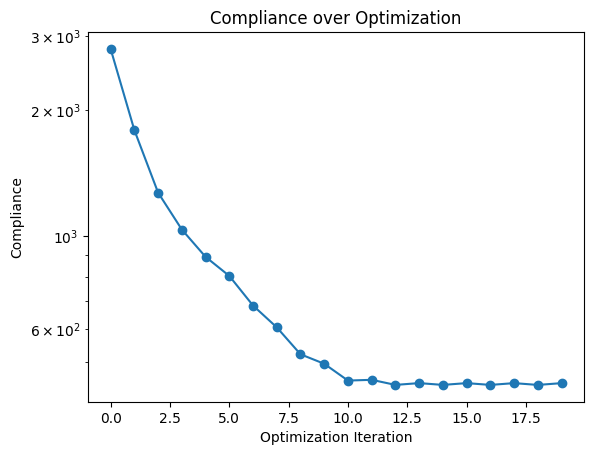

In [20]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [21]:
for i in range(n_steps):
    mesh = hex_mesh
    rho_dot = grad_storage[i + 2000][1][: len(mesh["faces"])]
    pv_mesh = hex_to_pyvista(
        mesh["points"], mesh["faces"], {"rho": aux_hist[i]["rho_grid"].T.flatten(), "rho_dot": rho_dot.T.flatten()}
    )
    pv_mesh.save(f"vtks/fem_shapeopt_mesh{i + 1}.vtk")

In [22]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    sdf = aux["sdf"]

    im = plt.imshow((sdf[:, :, :] > 0).sum(axis=1).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_bars_optim.gif", writer="pillow", fps=10)